In [2]:
from datetime import datetime
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from src.env.DebugEnv import DebugEnv
import src.run_debug as run
import src.data_raw as data_raw
import src.load as load
import src.preprocess as preprocess

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

loading config from config/config.yml


In [3]:
def create_timedelta_and_plot(*, model, logy=True):
    times = model.env.get_attr('timer')
    times = pd.DataFrame(data=times[0], columns=['timestamp'])
    times['timestamp'] = pd.to_datetime(times['timestamp'])
    times['timestamp_1'] = times['timestamp'].shift(-1)
    times['timedelta'] = times['timestamp'].shift(-1)-times['timestamp']

    times = times.drop(times.loc[times['timedelta']<pd.to_timedelta(0)].index)
    times = times.drop(times.loc[times['timedelta']>pd.to_timedelta('1h')].index)

    times = times.dropna().reset_index(drop=True)

    times['timedelta'].plot(logy=logy)

In [4]:
%%time
data_raw.download_and_process()
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df)
config.n_cpu=1
env = run.setup_env(df=df)

Processed data avilable locsally, no downloading and raw data processing needed.
LOAD: Loading data with 2099760 samples
PREPROCESS: Dropping 109069 NaNs out of 2099760 samples (5.19%) from input file
PREPROCESS: Dropping unused data, 1990691 -> 50002 samples
Setting up environment using 1 cores...
Done.
CPU times: user 251 ms, sys: 228 ms, total: 479 ms
Wall time: 774 ms


RUN: Training for 8000000 serial timesteps and 8000000 total timesteps...
Done.
Avg time per serial timestep: 0.00112267816375
CPU times: user 2h 27min 37s, sys: 30min 54s, total: 2h 58min 31s
Wall time: 2h 29min 45s


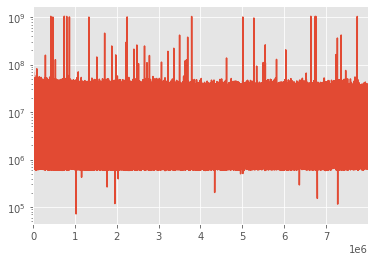

In [4]:
# also df
%%time
serial_timesteps = 8000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

In [6]:
%%time
# also rewards
serial_timesteps = 800000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

RUN: Training for 800000 serial timesteps and 800000 total timesteps...


KeyboardInterrupt: 

RUN: Training for 30000000 serial timesteps and 30000000 total timesteps...
Done.
Avg time per serial timestep: 0.0008447595279
CPU times: user 7h 5min 33s, sys: 2h 8min 33s, total: 9h 14min 6s
Wall time: 7h 2min 50s


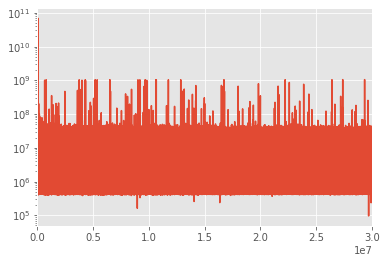

In [120]:
%%time
serial_timesteps = 30000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

# Testing reward calculation

In [11]:
window_size = 1


In [14]:
from datetime import datetime

In [18]:
for n in [100000, 1000000]:

    print(f'{n}:')
    net_worths = [np.random.uniform(low=8000, high=15000) for _ in range(0,n)]
    past = datetime.now()
    print(f'   A: {(datetime.now()-past).total_seconds()}')
    net_worths = pd.Series(net_worths)
    print(f'   B: {(datetime.now()-past).total_seconds()}')
    returns = net_worths.pct_change().dropna()
    print(f'   C: {(datetime.now()-past).total_seconds()}')
    returns = (1 + returns[-window_size:]).cumprod() - 1
    print(f'   Total time elapsed: {(datetime.now()-past).total_seconds()}')

100000:
   A: 1.9e-05
   B: 0.009043
   C: 0.015879
   Total time elapsed: 0.017083
1000000:
   A: 1.8e-05
   B: 0.07121
   C: 0.085731
   Total time elapsed: 0.086738


In [13]:
returns

99   -0.124673
dtype: float64